### Dual-Tree Complex Wavelet Packet Transforms (DT-CWPT)

- Basic understanding of Wavelet Packet Transforms:

    - [Understanding Wavelets, Part 1: What Are Wavelets](https://www.youtube.com/watch?v=QX1-xGVFqmw&list=PLn8PRpmsu08ojy02wi4QLVzELM545Xw3p&index=1)

    - [Understanding Wavelets, Part 2: Types of Wavelet Transforms](https://www.youtube.com/watch?v=F7Lg-nFYooU&list=PLn8PRpmsu08ojy02wi4QLVzELM545Xw3p&index=2)

- [Dual-Tree Complex Wavelet Packet Transform](https://web.itu.edu.tr/ibayram/dtcwpt/)

In [1]:
# DTCWPT

import numpy as np
from scipy.signal import convolve

def afb(x, lowpass, highpass):
    """
    Analysis Filter Bank (AFB)
    
    Parameters:
    x : input signal
    lowpass, highpass : analysis filters
    
    Returns:
    y : output -> [lowpass_channel, highpass_channel]
    """
    # Low-pass filter
    temp = convolve(x, lowpass, mode='full')
    temp[:len(temp) - len(x)] += temp[len(x):]
    y0 = temp[:len(x):2]
    
    # High-pass filter
    temp = convolve(x, highpass, mode='full')
    temp[:len(temp) - len(x)] += temp[len(x):]
    y1 = temp[:len(x):2]
    
    return np.vstack((y0, y1))

def DTCWPT(x, first, h, f, max_level):
    """
    Dual-Tree Complex Wavelet Packet Transform (DTCWPT)
    
    Parameters:
    x : input signal
    first: first stage filters ([first_lowpass, first_highpass]), also it is Daubechies filters with 5 and 6 vanishing moments
        *** Note: If need the first and the second DWPT, run seperately (2 times)
    h (g): Kingsbury's Q-shift filters ([h_lowpass, h_highpass]) or ([g_lowpass, g_highpass]) 
        *** Note: h is for the first DWPT, and g is for the second DWPT, run seperately (2 times)
    f : Daubechies filters with 5 and 6 vanishing moments ([f_lowpass, f_highpass])
    max_level : maximum level
    
    Returns:
    y : output list containing all of the branches
    """
    y = {}

    # First stage
    fil0 = first[0, :]
    fil1 = first[1, :]
    yy = afb(x, fil0, fil1) # Whenever need to seperate to lowpass and highpass, use afb function
    # print(yy)
    y[(1, 1)] = yy[0, :]
    # print(y[(1, 1)])
    y[(1, 2)] = yy[1, :]
    # print(y[(1, 2)])

    # Second stage
    fil0 = h[0, :]
    fil1 = h[1, :]
    yy = afb(y[(1, 1)], fil0, fil1)
    y[(2, 1)] = yy[0, :]
    # print(y[(2, 1)])
    y[(2, 2)] = yy[1, :]
    # print(y[(2, 2)])

    yy = afb(y[(1, 2)], fil0, fil1)
    y[(2, 3)] = yy[0, :]
    # print(y[(2, 3)])
    y[(2, 4)] = yy[1, :]
    # print(y[(2, 4)])

    for n in range(3, max_level + 1):
        for k in range(1, 2**(n - 1) + 1):
            if k % 2**(n - 2) == 1:
                fil0 = h[0, :]
                fil1 = h[1, :]
            else:
                fil0 = f[0, :]
                fil1 = f[1, :]
            yy = afb(y[(n - 1, k)], fil0, fil1)
            y[(n, 2 * k - 1)] = yy[0, :]
            y[(n, 2 * k)] = yy[1, :]

    return [y[(max_level, k)] for k in range(1, 2**max_level + 1)]

In [2]:
# IDTCWPT

import numpy as np
from scipy.signal import convolve

def sfb(y, lowpass, highpass):
    """
    Synthesis Filter Bank (SFB)
    
    Parameters:
    y : output from 'afb' function
    lowpass, highpass : synthesis filters
    
    Returns:
    x : reconstructed input
    """
    x0 = np.zeros(len(y) * 2)
    x1 = np.zeros(len(y) * 2)
    
    x0[::1] = y[0]
    x1[::1] = y[1]
    
    x = x0
    fil = lowpass
    temp = convolve(fil, x)
    temp[:len(temp)-len(x)] += temp[len(x):]
    take = temp[:len(x)]
    shift = len(fil)
    take0 = take[np.mod(np.arange(len(x)) + shift - 1, len(x))]
    
    x = x1
    fil = highpass
    temp = convolve(fil, x)
    temp[:len(temp)-len(x)] += temp[len(x):]
    take = temp[:len(x)]
    shift = len(fil)
    take = take[np.mod(np.arange(len(x)) + shift - 1, len(x))]
    
    x = take + take0
    
    return x

import numpy as np

def IDTCWPT(y, first, h, f):
    """
    Inverse Dual-Tree Complex Wavelet Packet Transform (IDTCWPT)
    
    Parameters:
    y : the cell array arranged as in DTCWPT
    first: first stage filters ([first_lowpass, first_highpass]), also it is Daubechies filters with 5 and 6 vanishing moments
    h (g): Kingsbury's Q-shift filters ([h_lowpass, h_highpass]) or ([g_lowpass, g_highpass]) 
    f : Daubechies filters with 5 and 6 vanishing moments ([f_lowpass, f_highpass])
    
    Returns:
    x : reconstructed input signal
    """
    max_level = int(np.log2(len(y)))
    # print(max_level)

    xx = y[0][:]
    # print(len(xx))

    for n in range(max_level, 2, -1):
        x2 = [None] * (2**(n-1))
        for k in range(1, 2**(n-1) + 1):
            if k % (2**(n-2)) == 1:
                fil0 = h[0]
                fil1 = h[1]
            else:
                fil0 = f[0]
                fil1 = f[1]
            x2[k-1] = sfb([xx[2*k-2], xx[2*k-1]], fil0, fil1)
        xx = x2

    # Second stage
    fil0 = h[0]
    fil1 = h[1]
    x2 = [None] * 4
    x2[0] = sfb([xx[0], xx[1]], fil0, fil1)
    x2[1] = sfb([xx[2], xx[3]], fil0, fil1)

    # First stage
    fil0 = first[0]
    fil1 = first[1]
    x = sfb([x2[0], x2[1]], fil0, fil1)

    return x

Filter banks:

In [44]:
# # Short FBs
# import scipy.io
# import numpy as np

# # Load the .mat file
# mat_file_path = 'DT-CWPT/dtcwpt_filters.mat'  # Replace with your .mat file path
# mat_contents = scipy.io.loadmat(mat_file_path)

# # Display the keys in the .mat file
# print("Keys in the .mat file:", mat_contents.keys())

# # List of variables to save
# variables_to_save = ['h', 'g', 'f', 'first_1', 'first_2']

# # Dictionary to store the variables as numpy arrays
# variables_dict = {}

# # Process each variable
# for var in variables_to_save:
#     if var in mat_contents:
#         variable_data = mat_contents[var]
#         # Ensure the variable is a 2-row matrix
#         if variable_data.shape[0] == 2:
#             variables_dict[var] = variable_data
#             print(f"Stored {var} in variables_dict")
#         else:
#             print(f"{var} is not a 2-row matrix, not stored")
#     else:
#         print(f"{var} not found in the .mat file")

# # Example usage: Accessing the variables from the dictionary
# for var in variables_dict:
#     print(f"{var}:")
#     print(variables_dict[var])

# # Now you can use the variables_dict in your further processing
# # Example: Accessing 'h' variable
# h_variable = variables_dict.get('h')
# print("h variable data:", h_variable)

In [3]:
# Long FBs
import scipy.io
import numpy as np

# Load the .mat file
mat_file_path = 'DT-CWPT/dtcwpt_filters_long.mat'  # Replace with your .mat file path
mat_contents = scipy.io.loadmat(mat_file_path)

# Display the keys in the .mat file
print("Keys in the .mat file:", mat_contents.keys())

# List of variables to save
variables_to_save = ['h', 'g', 'f', 'first_1', 'first_2']

# Dictionary to store the variables as numpy arrays
variables_dict = {}

# Process each variable
for var in variables_to_save:
    if var in mat_contents:
        variable_data = mat_contents[var]
        # Ensure the variable is a 2-row matrix
        if variable_data.shape[0] == 2:
            variables_dict[var] = variable_data
            print(f"Stored {var} in variables_dict")
        else:
            print(f"{var} is not a 2-row matrix, not stored")
    else:
        print(f"{var} not found in the .mat file")

# Example usage: Accessing the variables from the dictionary
for var in variables_dict:
    print(f"{var}:")
    print(variables_dict[var])

# Now you can use the variables_dict in your further processing
# Example: Accessing 'h' variable
h_variable = variables_dict.get('h')
print("h variable data:", h_variable)


Keys in the .mat file: dict_keys(['__header__', '__version__', '__globals__', 'h', 'g', 'f', 'first_1', 'first_2'])
Stored h in variables_dict
Stored g in variables_dict
Stored f in variables_dict
Stored first_1 in variables_dict
Stored first_2 in variables_dict
h:
[[ 0.00325314 -0.00388321  0.03466035 -0.0388728  -0.11720389  0.27529538
   0.75614564  0.56881042  0.01186609 -0.1067118   0.02382538  0.01702522
  -0.00543948 -0.0045569 ]
 [-0.0045569   0.00543948  0.01702522 -0.02382538 -0.1067118  -0.01186609
   0.56881042 -0.75614564  0.27529538  0.11720389 -0.0388728  -0.03466035
  -0.00388321 -0.00325314]]
g:
[[-0.0045569  -0.00543948  0.01702522  0.02382538 -0.1067118   0.01186609
   0.56881042  0.75614564  0.27529538 -0.11720389 -0.0388728   0.03466035
  -0.00388321  0.00325314]
 [ 0.00325314  0.00388321  0.03466035  0.0388728  -0.11720389 -0.27529538
   0.75614564 -0.56881042  0.01186609  0.1067118   0.02382538 -0.01702522
  -0.00543948  0.0045569 ]]
f:
[[ 6.46115344e-03  6.23647

- DTCWPT should be run two times, one for real part, the other one for imaginary part of the signal.
- Make Hilbert transform for the imaginary part before applying the second DTCWPT.
- Use Daubechies filters with 5 and 6 vanishing moments for first and f.
- Use Kingsbury's Q-shift filters for h (g)

In [4]:
# Apply DTCWPT on Flow:
## CDGR individual sample:

import pandas as pd

# Define the path to the CSV file
csv_file_path = '/nfs/turbo/med-kayvan-lab/Projects/PARDS/02-Data/02-EVENTS/Cleaned/CDGR/a_58_CDGR_39_1st (1).csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(csv_file_path)

# Display the column names
# print("Column names:", df.columns)
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291508 entries, 0 to 291507
Data columns (total 18 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Relative Time (sec)            291508 non-null  float64
 1   Time                           291508 non-null  object 
 2   CDGR - FiO₂                    291508 non-null  int64  
 3   CDGR - PEEP                    291508 non-null  float64
 4   CDGR - Set: VT in mL           291508 non-null  float64
 5   CDGR - Paw                     291508 non-null  int64  
 6   CDGR - Set: PEEP L             291508 non-null  float64
 7   CDGR - eVT                     291508 non-null  float64
 8   CDGR - PIP                     291508 non-null  float64
 9   CDGR - Pplat                   291508 non-null  float64
 10  CDGR - Flow                    291508 non-null  float64
 11  CDGR - iPress Wave             291508 non-null  float64
 12  GE - SpO2 1                   

In [5]:
# Hilbert transform:

import pandas as pd
import numpy as np
from scipy.signal import hilbert

# Perform Hilbert transform on the entire Flow column
df['CDGR - Flow (FTandBBF) - HT'] = np.abs(hilbert(df['CDGR - Flow (FTandBBF)'].values))

# Display the column names
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291508 entries, 0 to 291507
Data columns (total 19 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Relative Time (sec)            291508 non-null  float64
 1   Time                           291508 non-null  object 
 2   CDGR - FiO₂                    291508 non-null  int64  
 3   CDGR - PEEP                    291508 non-null  float64
 4   CDGR - Set: VT in mL           291508 non-null  float64
 5   CDGR - Paw                     291508 non-null  int64  
 6   CDGR - Set: PEEP L             291508 non-null  float64
 7   CDGR - eVT                     291508 non-null  float64
 8   CDGR - PIP                     291508 non-null  float64
 9   CDGR - Pplat                   291508 non-null  float64
 10  CDGR - Flow                    291508 non-null  float64
 11  CDGR - iPress Wave             291508 non-null  float64
 12  GE - SpO2 1                   

In [6]:
# First DWPT (a set of real-valued filters)

# Extract the necessary columns
flow_column = "CDGR - Flow (FTandBBF)"
window_column = "Tumbling_window"
flow_data = df[flow_column]
# print(len(flow_data))
window_data = df[window_column]
# print(len(window_data))

# Unique tumbling windows
tumbling_windows = window_data.unique()
print(len(tumbling_windows))

# Define filter coefficients
first = variables_dict['first_1']
print(first.shape)
h = variables_dict['h']
print(h.shape)
f = variables_dict['f']
print(f.shape)
max_level = 4

# Process each tumbling window
results = {}
inverse_results = {}

for window in tumbling_windows:
    # Extract data for the current tumbling window
    window_data = flow_data[df[window_column] == window].values
    
    # Apply DTCWPT
    dtcwpt_result = DTCWPT(window_data, first, h, f, max_level)
    
    # Reconstruct using IDTCWPT
    idtcwpt_result = IDTCWPT(dtcwpt_result, first, h, f)
    
    # Store the result
    results[window] = dtcwpt_result
    inverse_results[window] = idtcwpt_result

# Display results
for window, result in results.items():
    print(f"Window {window}:")
    print(f"Number of results: {len(result)}")
    print(f"Number of coefficients for each feature: {len(result[0])}")
    print(result)
    print(inverse_results)


5
(2, 28)
(2, 14)
(2, 28)
Window 1:
Number of results: 16
Number of coefficients for each feature: 3676
[array([ 3.4701896 , -2.45884194, 26.0558659 , ..., -6.37072583,
       -1.65763871,  1.30167019]), array([ 0.8030346 , -2.91897109,  0.72824284, ...,  0.64396935,
       -0.21203089, -0.27857949]), array([-1.17403397,  2.03520967,  2.13255267, ..., -0.01987263,
        0.03062331, -0.14938993]), array([ 0.14257033,  0.06990516, -0.1340063 , ...,  0.19009464,
        0.1897528 ,  0.38563935]), array([ 0.27117178,  0.67420105, -0.63360659, ..., -0.08994416,
        0.01606567, -0.17438955]), array([ 0.07809048,  0.03991902, -0.01717318, ..., -0.41132424,
       -0.1671577 ,  0.08527363]), array([ 0.0551106 ,  0.04035032,  0.02635115, ..., -0.03492499,
       -0.0078471 ,  0.09405296]), array([ 0.2617007 ,  0.03444783, -0.01603086, ...,  0.68102934,
       -1.27589487, -1.4456683 ]), array([ 0.04109274,  0.06044239, -0.0304511 , ...,  0.01325811,
       -0.04889528,  0.02259487]), arra

In [7]:
real_idtcwpt = inverse_results
real_idtcwpt

{1: array([-37.18648911,   9.96768642,  12.43646667, -14.66993015]),
 2: array([ 0.57276135,  0.0011473 , -0.56633064, -0.39376255]),
 3: array([ 11.92140144,  -1.06234421, -16.24257685, -12.75683459]),
 4: array([ 2.65385493, -7.95044174, 15.66730354, 28.53524749]),
 5: array([ 40.9092017 , -11.36814657, -14.66428729,  15.25893022])}

In [8]:
# Second DWPT (a set of imaginary (or quadrature) filters)

# Extract the necessary columns
flow_column = "CDGR - Flow (FTandBBF) - HT"
window_column = "Tumbling_window"
flow_data = df[flow_column]
# print(len(flow_data))
window_data = df[window_column]
# print(len(window_data))

# Unique tumbling windows
tumbling_windows = window_data.unique()
print(len(tumbling_windows))

# Define filter coefficients
first = variables_dict['first_2']
print(first.shape)
g = variables_dict['g']
print(h.shape)
f = variables_dict['f']
print(f.shape)
max_level = 4

# Process each tumbling window
results = {}
inverse_results = {}

for window in tumbling_windows:
    # Extract data for the current tumbling window
    window_data = flow_data[df[window_column] == window].values
    
    # Apply DTCWPT
    dtcwpt_result = DTCWPT(window_data, first, g, f, max_level)
    
    # Reconstruct using IDTCWPT
    idtcwpt_result = IDTCWPT(dtcwpt_result, first, g, f)
    
    # Store the result
    results[window] = dtcwpt_result
    inverse_results[window] = idtcwpt_result

# Display results
for window, result in results.items():
    print(f"Window {window}:")
    print(f"Number of results: {len(result)}")
    print(f"Number of coefficients for each feature: {len(result[0])}")
    print(result)
    print(inverse_results)


5
(2, 29)
(2, 14)
(2, 28)
Window 1:
Number of results: 16
Number of coefficients for each feature: 3676
[array([29.50451794, 35.74997386, 65.02128485, ..., 19.03364406,
       24.82516492, 26.64712054]), array([ 2.2086015 ,  1.24472092, -2.85382693, ...,  0.56879089,
       -0.00327241,  0.21217521]), array([ 0.58688761, -0.21944861, -1.88255928, ...,  0.01085553,
        0.104448  ,  0.56687973]), array([ 0.06515062,  0.07996508, -0.1185612 , ..., -0.05729362,
       -0.09731726,  0.18611552]), array([-0.06316731, -1.45472068,  0.62794313, ..., -0.06804275,
        0.11279485,  0.34785767]), array([ 0.06461431,  0.04067694, -0.04328055, ...,  0.0084094 ,
        0.13445079,  0.16785526]), array([ 0.06001139,  0.0196125 ,  0.0391962 , ..., -0.03455399,
        0.00357278,  0.15797102]), array([ 0.17337128,  0.24893871,  0.01501586, ..., -0.46302857,
        1.1580172 ,  1.09797925]), array([-0.02417282, -0.04111018, -0.11106069, ..., -0.06681201,
       -0.09918498,  0.00086486]), arra

In [9]:
imag_idtcwpt = inverse_results
imag_idtcwpt

{1: array([-32.01217401, -23.57137362,   1.33981864,  -6.01462122]),
 2: array([-5.33437828, -6.58986036, -5.37597567, -4.94001322]),
 3: array([-27.85733592, -40.50407901, -39.07910153, -30.00268394]),
 4: array([-28.23733882, -40.6400465 , -39.71800077, -32.44811802]),
 5: array([-31.94384298, -32.04111575, -16.45526996, -18.28861481])}

In [11]:
# Apply DTCWPT to CDGR (all):

import os
import pandas as pd
import numpy as np
from scipy.signal import hilbert

# Define the directory containing the CSV files
input_dir = "/nfs/turbo/med-kayvan-lab/Projects/PARDS/02-Data/02-EVENTS/Cleaned/CDGR/"
output_dir = "/nfs/turbo/med-kayvan-lab/Projects/PARDS/02-Data/02-EVENTS/Cleaned/CDGR/Flow_DTCWPT/"

# Define the necessary column names
flow_column = "CDGR - Flow (FTandBBF)"
window_column = "Tumbling_window"
hilbert_column = f"{flow_column} - HT"

# Define filter coefficients and other parameters (replace with your actual values)
first_real = variables_dict['first_1']
h = variables_dict['h']
f = variables_dict['f']
first_imaginary = variables_dict['first_2']
g = variables_dict['g']
max_level = 4

# Function to save features for a window
def save_features(window, real_result, imag_result, filename):
    """Saves real and imaginary features for a window to separate files.

    Args:
    window: Window identifier (e.g., tumbling window number).
    real_result: Real-valued DTCWPT coefficients for the window.
    imag_result: Imaginary-valued DTCWPT coefficients for the window.
    filename: Base filename for the file (without window and feature suffixes).
    """
    # Save real features
    real_filename = f"{output_dir}/{filename}_w{window}_real.csv"
    np.savetxt(real_filename, real_result, delimiter=',')

    # Save imaginary features
    imag_filename = f"{output_dir}/{filename}_w{window}_imag.csv"
    np.savetxt(imag_filename, imag_result, delimiter=',')

# Process each CSV file in the input directory
for filename in os.listdir(input_dir):
    if filename.endswith(".csv"):
    filepath = os.path.join(input_dir, filename)
    df = pd.read_csv(filepath)

    # Perform Hilbert transform on the entire Flow column
    df[hilbert_column] = np.abs(hilbert(df[flow_column].values))

    # Apply the first DWPT (real-valued filters)
    flow_data = df[flow_column]
    window_data = df[window_column]
    tumbling_windows = window_data.unique()
    results_real = {}

    for window in tumbling_windows:
        window_flow_data = flow_data[df[window_column] == window].values
        dtcwpt_result_real = DTCWPT(window_flow_data, first_real, h, f, max_level)
        results_real[window] = dtcwpt_result_real

        # Apply the second DWPT (imaginary filters)
        window_hilbert_data = df[hilbert_column][df[window_column] == window].values
        dtcwpt_result_imaginary = DTCWPT(window_hilbert_data, first_imaginary, g, f, max_level)
        results_imaginary[window] = dtcwpt_result_imaginary

        # Save features for the current window
        save_features(window, results_real[window], results_imaginary[window], filename)

print(f"Processed all files and saved features to {output_dir}")

In [10]:
import pandas as pd
import os

# Directory where the files are stored
directory_path = "/nfs/turbo/med-kayvan-lab/Projects/PARDS/02-Data/02-EVENTS/Cleaned/CDGR/Flow_DTCWPT/"

# List of base file names
base_file_names = [
    f"a_58_CDGR_39_1st ({i}).csv" for i in range(1, 40) if i not in [10, 36]
] + [
    f"b_151_CDGR_11_1st ({i}).csv" for i in range(1, 12)
]

# Function to process each group of files
def process_files(base_file_name):
    # List of file names for the current base file
    file_names = [
        f"{base_file_name}_w1_real.csv", f"{base_file_name}_w1_imag.csv",
        f"{base_file_name}_w2_real.csv", f"{base_file_name}_w2_imag.csv",
        f"{base_file_name}_w3_real.csv", f"{base_file_name}_w3_imag.csv",
        f"{base_file_name}_w4_real.csv", f"{base_file_name}_w4_imag.csv",
        f"{base_file_name}_w5_real.csv", f"{base_file_name}_w5_imag.csv"
    ]

    # Initialize an empty list to hold DataFrames
    dataframes = []

    # Loop through each file
    for file in file_names:
        # Construct the full file path
        file_path = os.path.join(directory_path, file)
        
        # Read the CSV file
        df = pd.read_csv(file_path, header=None)
        
        # Transpose the DataFrame
        df_transposed = df.T
        
        # Generate column names based on the file name without '.csv' and in the format f{i}
        file_base = os.path.basename(file).replace(".csv", "")
        df_transposed.columns = [f"{file_base}_f{i+1}" for i in range(df_transposed.shape[1])]
        
        # Append the transposed DataFrame to the list
        dataframes.append(df_transposed)

    # Concatenate all DataFrames
    final_df = pd.concat(dataframes, axis=1)

    # Define the output file name without ".csv"
    output_file_base = base_file_name.replace(".csv", "")
    output_file_name = f"{output_file_base}_Flow_DTCWPT.csv"
    output_file_path = os.path.join(directory_path, output_file_name)

    # Save the concatenated DataFrame to the new CSV file
    final_df.to_csv(output_file_path, index=False)

    print(f"CSV files for {base_file_name} have been concatenated and saved as {output_file_path}")

# Loop through each base file name
for base_file_name in base_file_names:
    process_files(base_file_name)


CSV files for a_58_CDGR_39_1st (1).csv have been concatenated and saved as /nfs/turbo/med-kayvan-lab/Projects/PARDS/02-Data/02-EVENTS/Cleaned/CDGR/Flow_DTCWPT/a_58_CDGR_39_1st (1)_Flow_DTCWPT.csv
CSV files for a_58_CDGR_39_1st (2).csv have been concatenated and saved as /nfs/turbo/med-kayvan-lab/Projects/PARDS/02-Data/02-EVENTS/Cleaned/CDGR/Flow_DTCWPT/a_58_CDGR_39_1st (2)_Flow_DTCWPT.csv
CSV files for a_58_CDGR_39_1st (3).csv have been concatenated and saved as /nfs/turbo/med-kayvan-lab/Projects/PARDS/02-Data/02-EVENTS/Cleaned/CDGR/Flow_DTCWPT/a_58_CDGR_39_1st (3)_Flow_DTCWPT.csv
CSV files for a_58_CDGR_39_1st (4).csv have been concatenated and saved as /nfs/turbo/med-kayvan-lab/Projects/PARDS/02-Data/02-EVENTS/Cleaned/CDGR/Flow_DTCWPT/a_58_CDGR_39_1st (4)_Flow_DTCWPT.csv
CSV files for a_58_CDGR_39_1st (5).csv have been concatenated and saved as /nfs/turbo/med-kayvan-lab/Projects/PARDS/02-Data/02-EVENTS/Cleaned/CDGR/Flow_DTCWPT/a_58_CDGR_39_1st (5)_Flow_DTCWPT.csv
CSV files for a_58_C

In [27]:
# Apply DTCWPT to AVEAA (all):

import os
import pandas as pd
import numpy as np
from scipy.signal import hilbert

# Define the directory containing the CSV files
input_dir = "/nfs/turbo/med-kayvan-lab/Projects/PARDS/02-Data/02-EVENTS/Cleaned/AVEAA/"
output_dir = "/nfs/turbo/med-kayvan-lab/Projects/PARDS/02-Data/02-EVENTS/Cleaned/AVEAA/Flow_DTCWPT/"

# Define the necessary column names
flow_column = "AVEA - Air Flow Wave (FTandBBF)"
window_column = "Tumbling_window"
hilbert_column = f"{flow_column} - HT"

# Define filter coefficients and other parameters (replace with your actual values)
first_real = variables_dict['first_1']
h = variables_dict['h']
f = variables_dict['f']
first_imaginary = variables_dict['first_2']
g = variables_dict['g']
max_level = 4

# Function to save features for a window
def save_features(window, real_result, imag_result, filename):
    """Saves real and imaginary features for a window to separate files.

    Args:
    window: Window identifier (e.g., tumbling window number).
    real_result: Real-valued DTCWPT coefficients for the window.
    imag_result: Imaginary-valued DTCWPT coefficients for the window.
    filename: Base filename for the file (without window and feature suffixes).
    """
    # Save real features
    real_filename = f"{output_dir}/{filename}_w{window}_real.csv"
    np.savetxt(real_filename, real_result, delimiter=',')

    # Save imaginary features
    imag_filename = f"{output_dir}/{filename}_w{window}_imag.csv"
    np.savetxt(imag_filename, imag_result, delimiter=',')

# Process each CSV file in the input directory
for filename in os.listdir(input_dir):
    if filename.endswith(".csv"):
    filepath = os.path.join(input_dir, filename)
    df = pd.read_csv(filepath)

    # Perform Hilbert transform on the entire Flow column
    df[hilbert_column] = np.abs(hilbert(df[flow_column].values))

    # Apply the first DWPT (real-valued filters)
    flow_data = df[flow_column]
    window_data = df[window_column]
    tumbling_windows = window_data.unique()
    results_real = {}

    for window in tumbling_windows:
        window_flow_data = flow_data[df[window_column] == window].values
        dtcwpt_result_real = DTCWPT(window_flow_data, first_real, h, f, max_level)
        results_real[window] = dtcwpt_result_real

        # Apply the second DWPT (imaginary filters)
        window_hilbert_data = df[hilbert_column][df[window_column] == window].values
        dtcwpt_result_imaginary = DTCWPT(window_hilbert_data, first_imaginary, g, f, max_level)
        results_imaginary[window] = dtcwpt_result_imaginary

        # Save features for the current window
        save_features(window, results_real[window], results_imaginary[window], filename)

print(f"Processed all files and saved features to {output_dir}")


Processed all files and saved features to /nfs/turbo/med-kayvan-lab/Projects/PARDS/02-Data/02-EVENTS/Cleaned/AVEAA/Flow_DTCWPT/


In [9]:
import pandas as pd
import os

# Directory where the files are stored
directory_path = "/nfs/turbo/med-kayvan-lab/Projects/PARDS/02-Data/02-EVENTS/Cleaned/AVEAA/Flow_DTCWPT/"

# List of base file names without the w1, w2, etc.
base_file_names = [
    "a_58_AVEAA_4_1st (1).csv",
    "a_58_AVEAA_4_1st (2).csv",
    "a_58_AVEAA_4_1st (3).csv",
    "a_58_AVEAA_4_1st (4).csv",
    "b_151_AVEAA_4_1st (1).csv",
    "b_151_AVEAA_4_1st (2).csv",
    "b_151_AVEAA_4_1st (3).csv",
    "b_151_AVEAA_4_1st (4).csv"
]

# Function to process each group of files
def process_files(base_file_name):
    # List of file names for the current base file
    file_names = [
        f"{base_file_name}_w1_real.csv", f"{base_file_name}_w1_imag.csv",
        f"{base_file_name}_w2_real.csv", f"{base_file_name}_w2_imag.csv",
        f"{base_file_name}_w3_real.csv", f"{base_file_name}_w3_imag.csv",
        f"{base_file_name}_w4_real.csv", f"{base_file_name}_w4_imag.csv",
        f"{base_file_name}_w5_real.csv", f"{base_file_name}_w5_imag.csv"
    ]

    # Initialize an empty list to hold DataFrames
    dataframes = []

    # Loop through each file
    for file in file_names:
        # Construct the full file path
        file_path = os.path.join(directory_path, file)
        
        # Read the CSV file
        df = pd.read_csv(file_path, header=None)
        
        # Transpose the DataFrame
        df_transposed = df.T
        
        # Generate column names based on the file name without '.csv' and in the format f{i}
        file_base = os.path.basename(file).replace(".csv", "")
        df_transposed.columns = [f"{file_base}_f{i+1}" for i in range(df_transposed.shape[1])]
        
        # Append the transposed DataFrame to the list
        dataframes.append(df_transposed)

    # Concatenate all DataFrames
    final_df = pd.concat(dataframes, axis=1)

    # Define the output file name without ".csv"
    output_file_base = base_file_name.replace(".csv", "")
    output_file_name = f"{output_file_base}_Flow_DTCWPT.csv"
    output_file_path = os.path.join(directory_path, output_file_name)

    # Save the concatenated DataFrame to the new CSV file
    final_df.to_csv(output_file_path, index=False)

    print(f"CSV files for {base_file_name} have been concatenated and saved as {output_file_path}")

# Loop through each base file name
for base_file_name in base_file_names:
    process_files(base_file_name)


CSV files for a_58_AVEAA_4_1st (1).csv have been concatenated and saved as /nfs/turbo/med-kayvan-lab/Projects/PARDS/02-Data/02-EVENTS/Cleaned/AVEAA/Flow_DTCWPT/a_58_AVEAA_4_1st (1)_Flow_DTCWPT.csv
CSV files for a_58_AVEAA_4_1st (2).csv have been concatenated and saved as /nfs/turbo/med-kayvan-lab/Projects/PARDS/02-Data/02-EVENTS/Cleaned/AVEAA/Flow_DTCWPT/a_58_AVEAA_4_1st (2)_Flow_DTCWPT.csv
CSV files for a_58_AVEAA_4_1st (3).csv have been concatenated and saved as /nfs/turbo/med-kayvan-lab/Projects/PARDS/02-Data/02-EVENTS/Cleaned/AVEAA/Flow_DTCWPT/a_58_AVEAA_4_1st (3)_Flow_DTCWPT.csv
CSV files for a_58_AVEAA_4_1st (4).csv have been concatenated and saved as /nfs/turbo/med-kayvan-lab/Projects/PARDS/02-Data/02-EVENTS/Cleaned/AVEAA/Flow_DTCWPT/a_58_AVEAA_4_1st (4)_Flow_DTCWPT.csv
CSV files for b_151_AVEAA_4_1st (1).csv have been concatenated and saved as /nfs/turbo/med-kayvan-lab/Projects/PARDS/02-Data/02-EVENTS/Cleaned/AVEAA/Flow_DTCWPT/b_151_AVEAA_4_1st (1)_Flow_DTCWPT.csv
CSV files for

##### Check the DTCWPT results (i.e. features) quality.

In [4]:
import pandas as pd
import os
import re

# Define paths
cdgr_path = "/nfs/turbo/med-kayvan-lab/Projects/PARDS/02-Data/02-EVENTS/Cleaned/CDGR/Flow_DTCWPT/"
aveaa_path = "/nfs/turbo/med-kayvan-lab/Projects/PARDS/02-Data/02-EVENTS/Cleaned/AVEAA/Flow_DTCWPT/"

# List all csv files in the directories
cdgr_files = [os.path.join(cdgr_path, f) for f in os.listdir(cdgr_path) if f.endswith('.csv')]
aveaa_files = [os.path.join(aveaa_path, f) for f in os.listdir(aveaa_path) if f.endswith('.csv')]

# Combine the list of files
all_files = cdgr_files + aveaa_files

# Initialize an empty list to store dataframes
dataframes = []

# Function to standardize column names
def standardize_columns(columns):
    standardized_columns = []
    pattern = re.compile(r'_(w\d+)_([^_]+)_(f\d+)$')
    for col in columns:
        match = pattern.search(col)
        if match:
            standardized_columns.append(f"{match.group(1)}_{match.group(2)}_{match.group(3)}")
        else:
            standardized_columns.append(col)
    return standardized_columns

# Read CSV files and standardize column names, adding a 'source_file' column
for file in all_files:
    df = pd.read_csv(file)
    df.columns = standardize_columns(df.columns)
    # Add a column indicating the source file name
    df['source_file'] = os.path.basename(file)  # Extracts the filename without path
    dataframes.append(df)

# Concatenate all dataframes row-wise, ensuring proper alignment of columns
combined_df = pd.concat(dataframes, axis=0, ignore_index=True)

# Ensure the final DataFrame has 160 columns by reordering and filling missing columns
expected_columns = [f"w{i+1}_{part}_f{j+1}" for i in range(5) for part in ["real", "imag"] for j in range(16)]
for col in expected_columns:
    if col not in combined_df.columns:
        combined_df[col] = pd.NA

combined_df = combined_df[expected_columns + ['source_file']]  # Include 'source_file' column

# # Optionally, save the combined dataframe to a new CSV file
# combined_csv_path = "/nfs/turbo/med-kayvan-lab/Projects/PARDS/02-Data/02-EVENTS/Cleaned/combined_flow_dtcwpt.csv"
# combined_df.to_csv(combined_csv_path, index=False)

print(f"Combined DataFrame shape: {combined_df.shape}")


Combined DataFrame shape: (207941, 161)


In [5]:
flow_dtcwpt = combined_df
flow_dtcwpt.shape

(207941, 161)

In [6]:
len(flow_dtcwpt['source_file'].unique())

56

In [9]:
flow_dtcwpt

,w1_real_f1,w1_real_f2,w1_real_f3,w1_real_f4,w1_real_f5,w1_real_f6,w1_real_f7,w1_real_f8,w1_real_f9,w1_real_f10,...,w5_imag_f8,w5_imag_f9,w5_imag_f10,w5_imag_f11,w5_imag_f12,w5_imag_f13,w5_imag_f14,w5_imag_f15,w5_imag_f16,source_file
0,50.298197,5.475080,-0.898276,0.263702,-0.050868,0.021179,1.020258,0.927120,-0.061115,0.017855,...,0.612003,0.100031,-0.010723,-0.006325,-0.147030,-0.607882,-0.100242,0.018757,0.143953,b_151_CDGR_11_1st (8)_Flow_DTCWPT.csv
1,9.622563,-14.034597,-1.046227,-0.228295,-0.041369,0.028145,2.593933,-0.376807,0.007181,0.078410,...,-0.104106,0.115765,-0.025828,-0.219307,0.388138,-1.243866,-0.327563,-0.026430,-0.102086,b_151_CDGR_11_1st (8)_Flow_DTCWPT.csv
2,-29.473965,6.181245,0.469609,-0.479164,-0.024040,-0.087874,-0.766595,-0.083135,-0.024015,0.010284,...,-0.947663,0.161956,-0.021656,-0.981803,0.167093,0.900945,-0.069171,0.022836,0.780786,b_151_CDGR_11_1st (8)_Flow_DTCWPT.csv
3,-17.964521,-2.943688,0.072497,0.216680,0.057879,-0.042176,0.823099,-0.021073,-0.049861,0.067602,...,0.353678,0.518343,0.345244,-0.210571,-0.055327,-0.293205,0.032091,0.032834,0.094883,b_151_CDGR_11_1st (8)_Flow_DTCWPT.csv
4,-13.636235,-0.780817,0.155200,-0.005797,0.102119,0.005507,2.091983,-0.012066,0.029207,-0.039739,...,-0.403240,-0.123195,-0.586365,0.229112,-0.025655,0.837130,0.065916,0.012996,-0.161020,b_151_CDGR_11_1st (8)_Flow_DTCWPT.csv
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207936,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,b_151_AVEAA_4_1st (4)_Flow_DTCWPT.csv
207937,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,b_151_AVEAA_4_1st (4)_Flow_DTCWPT.csv
207938,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,b_151_AVEAA_4_1st (4)_Flow_DTCWPT.csv
207939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,b_151_AVEAA_4_1st (4)_Flow_DTCWPT.csv


In [7]:
%store flow_dtcwpt

Stored 'flow_dtcwpt' (DataFrame)


#####################################################################

In [1]:
%store -r flow_dtcwpt
flow_dtcwpt.shape

(207941, 161)

In [2]:
flow_dtcwpt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207941 entries, 0 to 207940
Columns: 161 entries, w1_real_f1 to source_file
dtypes: float64(160), object(1)
memory usage: 255.4+ MB


In [3]:
%store -r pards_1st_df
pards_1st_df.shape

(16256611, 10)

In [4]:
pards_1st_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16256611 entries, 0 to 16256610
Data columns (total 10 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Time             object 
 1   PIP              float64
 2   PEEP             float64
 3   Flow             float64
 4   TV(mL/kg)        float64
 5   TV(mL/kg)_ma     float64
 6   Tumbling_window  int64  
 7   OSI              float64
 8   PID              float64
 9   Source_File      object 
dtypes: float64(7), int64(1), object(2)
memory usage: 1.2+ GB


In [5]:
import pandas as pd

# Group by 'Source_File' and count the number of rows for each group
osi_counts = pards_1st_df.groupby('Source_File').size().reset_index(name='OSI_Count')

# Display the counts
print(osi_counts)


                   Source_File  OSI_Count
0     a_58_AVEAA_4_1st (1).csv     291966
1     a_58_AVEAA_4_1st (2).csv     291798
2     a_58_AVEAA_4_1st (3).csv     301289
3     a_58_AVEAA_4_1st (4).csv     297019
4     a_58_CDGR_39_1st (1).csv     291508
5    a_58_CDGR_39_1st (11).csv     291396
6    a_58_CDGR_39_1st (12).csv     290551
7    a_58_CDGR_39_1st (13).csv     285213
8    a_58_CDGR_39_1st (14).csv     293210
9    a_58_CDGR_39_1st (15).csv     287008
10   a_58_CDGR_39_1st (16).csv     292108
11   a_58_CDGR_39_1st (17).csv     293307
12   a_58_CDGR_39_1st (18).csv     292303
13   a_58_CDGR_39_1st (19).csv     281183
14    a_58_CDGR_39_1st (2).csv     290661
15   a_58_CDGR_39_1st (20).csv     294824
16   a_58_CDGR_39_1st (21).csv     232139
17   a_58_CDGR_39_1st (22).csv     293200
18   a_58_CDGR_39_1st (23).csv     281231
19   a_58_CDGR_39_1st (24).csv     292368
20   a_58_CDGR_39_1st (25).csv     285077
21   a_58_CDGR_39_1st (26).csv     290028
22   a_58_CDGR_39_1st (27).csv    

In [6]:
# Chunk the OSI size to match Flow DTCWPT feature size
import pandas as pd
from collections import Counter

def mean_of_chunks(df, chunk_size=100):
    # Split the DataFrame into chunks of the given size
    chunks = [df.iloc[i:i + chunk_size] for i in range(0, len(df), chunk_size)]
    
    # Calculate the mean of the 'OSI' column for each chunk
    chunk_means = [round(chunk['OSI'].mean(), 2) for chunk in chunks]
    
    # Calculate the majority number in the 'Tumbling_window' column for each chunk
    chunk_majorities = [Counter(chunk['Tumbling_window']).most_common(1)[0][0] for chunk in chunks]
    
    return chunk_means, chunk_majorities

# Apply the function to each group of 'Source_File'
result = pards_1st_df.groupby('Source_File').apply(lambda x: mean_of_chunks(x, chunk_size=100))

# Flatten the result into a DataFrame
chunk_means, chunk_majorities = zip(*result)

# Create a DataFrame for the means and majorities
result_df_means = pd.Series([item for sublist in chunk_means for item in sublist], name='OSI_Mean')
result_df_majorities = pd.Series([item for sublist in chunk_majorities for item in sublist], name='TW_New')

# Create a DataFrame to keep track of the Source_File groups
source_files = pd.Series([file for file, sublist in zip(result.index, chunk_means) for _ in sublist], name='Source_File')

# Combine the Series into a DataFrame
result_df = pd.concat([source_files, result_df_means, result_df_majorities], axis=1)
OSI_chunks = result_df

# Display the result
print(OSI_chunks)

                      Source_File  OSI_Mean  TW_New
0        a_58_AVEAA_4_1st (1).csv      2.80       1
1        a_58_AVEAA_4_1st (1).csv      2.80       1
2        a_58_AVEAA_4_1st (1).csv      2.80       1
3        a_58_AVEAA_4_1st (1).csv      2.80       1
4        a_58_AVEAA_4_1st (1).csv      2.80       1
...                           ...       ...     ...
162588  b_151_CDGR_11_1st (9).csv      2.05       5
162589  b_151_CDGR_11_1st (9).csv      2.06       5
162590  b_151_CDGR_11_1st (9).csv      2.06       5
162591  b_151_CDGR_11_1st (9).csv      2.06       5
162592  b_151_CDGR_11_1st (9).csv      2.06       5

[162593 rows x 3 columns]


In [7]:
import pandas as pd

# Assuming pards_1st_df is already loaded
# Group by 'Source_File' and count the number of rows for each group
osi_counts = OSI_chunks.groupby('Source_File').size().reset_index(name='OSI_Count')

# Display the counts
print(osi_counts)

                   Source_File  OSI_Count
0     a_58_AVEAA_4_1st (1).csv       2920
1     a_58_AVEAA_4_1st (2).csv       2918
2     a_58_AVEAA_4_1st (3).csv       3013
3     a_58_AVEAA_4_1st (4).csv       2971
4     a_58_CDGR_39_1st (1).csv       2916
5    a_58_CDGR_39_1st (11).csv       2914
6    a_58_CDGR_39_1st (12).csv       2906
7    a_58_CDGR_39_1st (13).csv       2853
8    a_58_CDGR_39_1st (14).csv       2933
9    a_58_CDGR_39_1st (15).csv       2871
10   a_58_CDGR_39_1st (16).csv       2922
11   a_58_CDGR_39_1st (17).csv       2934
12   a_58_CDGR_39_1st (18).csv       2924
13   a_58_CDGR_39_1st (19).csv       2812
14    a_58_CDGR_39_1st (2).csv       2907
15   a_58_CDGR_39_1st (20).csv       2949
16   a_58_CDGR_39_1st (21).csv       2322
17   a_58_CDGR_39_1st (22).csv       2932
18   a_58_CDGR_39_1st (23).csv       2813
19   a_58_CDGR_39_1st (24).csv       2924
20   a_58_CDGR_39_1st (25).csv       2851
21   a_58_CDGR_39_1st (26).csv       2901
22   a_58_CDGR_39_1st (27).csv    

In [8]:
OSI_chunks.shape

(162593, 3)

In [9]:
OSI_chunks.isna().sum()

Source_File     0
OSI_Mean       84
TW_New          0
dtype: int64

In [10]:
# Drop missing values
OSI_chunks_sub = OSI_chunks.dropna()
OSI_chunks_sub.shape

(162509, 3)

In [11]:
OSI_chunks_sub.isna().sum()

Source_File    0
OSI_Mean       0
TW_New         0
dtype: int64

In [12]:
OSI_chunks_sub

,Source_File,OSI_Mean,TW_New
0,a_58_AVEAA_4_1st (1).csv,2.80,1
1,a_58_AVEAA_4_1st (1).csv,2.80,1
2,a_58_AVEAA_4_1st (1).csv,2.80,1
3,a_58_AVEAA_4_1st (1).csv,2.80,1
4,a_58_AVEAA_4_1st (1).csv,2.80,1
...,...,...,...
162588,b_151_CDGR_11_1st (9).csv,2.05,5
162589,b_151_CDGR_11_1st (9).csv,2.06,5
162590,b_151_CDGR_11_1st (9).csv,2.06,5
162591,b_151_CDGR_11_1st (9).csv,2.06,5


In [13]:
flow_dtcwpt.shape

(207941, 161)

In [14]:
flow_dtcwpt.isna().sum()

w1_real_f1      1959
w1_real_f2      1959
w1_real_f3      1959
w1_real_f4      1959
w1_real_f5      1959
               ...  
w5_imag_f13    12542
w5_imag_f14    12542
w5_imag_f15    12542
w5_imag_f16    12542
source_file        0
Length: 161, dtype: int64

In [15]:
# Drop missing values
flow_dtcwpt_sub = flow_dtcwpt.dropna()
flow_dtcwpt_sub.shape

(190659, 161)

In [16]:
flow_dtcwpt_sub.isna().sum()

w1_real_f1     0
w1_real_f2     0
w1_real_f3     0
w1_real_f4     0
w1_real_f5     0
              ..
w5_imag_f13    0
w5_imag_f14    0
w5_imag_f15    0
w5_imag_f16    0
source_file    0
Length: 161, dtype: int64

In [17]:
flow_dtcwpt_sub

,w1_real_f1,w1_real_f2,w1_real_f3,w1_real_f4,w1_real_f5,w1_real_f6,w1_real_f7,w1_real_f8,w1_real_f9,w1_real_f10,...,w5_imag_f8,w5_imag_f9,w5_imag_f10,w5_imag_f11,w5_imag_f12,w5_imag_f13,w5_imag_f14,w5_imag_f15,w5_imag_f16,source_file
0,50.298197,5.475080,-0.898276,0.263702,-0.050868,0.021179,1.020258,0.927120,-0.061115,0.017855,...,0.612003,0.100031,-0.010723,-0.006325,-0.147030,-0.607882,-0.100242,0.018757,0.143953,b_151_CDGR_11_1st (8)_Flow_DTCWPT.csv
1,9.622563,-14.034597,-1.046227,-0.228295,-0.041369,0.028145,2.593933,-0.376807,0.007181,0.078410,...,-0.104106,0.115765,-0.025828,-0.219307,0.388138,-1.243866,-0.327563,-0.026430,-0.102086,b_151_CDGR_11_1st (8)_Flow_DTCWPT.csv
2,-29.473965,6.181245,0.469609,-0.479164,-0.024040,-0.087874,-0.766595,-0.083135,-0.024015,0.010284,...,-0.947663,0.161956,-0.021656,-0.981803,0.167093,0.900945,-0.069171,0.022836,0.780786,b_151_CDGR_11_1st (8)_Flow_DTCWPT.csv
3,-17.964521,-2.943688,0.072497,0.216680,0.057879,-0.042176,0.823099,-0.021073,-0.049861,0.067602,...,0.353678,0.518343,0.345244,-0.210571,-0.055327,-0.293205,0.032091,0.032834,0.094883,b_151_CDGR_11_1st (8)_Flow_DTCWPT.csv
4,-13.636235,-0.780817,0.155200,-0.005797,0.102119,0.005507,2.091983,-0.012066,0.029207,-0.039739,...,-0.403240,-0.123195,-0.586365,0.229112,-0.025655,0.837130,0.065916,0.012996,-0.161020,b_151_CDGR_11_1st (8)_Flow_DTCWPT.csv
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207316,-24.001552,2.481042,1.388371,-3.360590,0.949767,3.539910,-0.320589,0.344852,0.071348,0.000477,...,-1.420998,-0.301630,-0.011037,-0.043481,0.322143,-0.442312,1.293490,0.005818,-0.330024,b_151_AVEAA_4_1st (4)_Flow_DTCWPT.csv
207317,-28.664404,-22.233661,3.555632,-17.101188,0.289744,2.290465,-0.353396,0.366689,0.025161,0.031480,...,1.837324,-0.353386,0.081130,-0.127794,-1.000250,0.117430,0.883800,-0.080870,0.184526,b_151_AVEAA_4_1st (4)_Flow_DTCWPT.csv
207318,135.390314,36.771330,0.724235,-6.346521,-0.500913,0.671351,0.094252,0.095766,0.083199,0.006235,...,-2.238226,-0.413748,-0.017910,-0.171955,-0.421065,-0.157515,-0.020290,-0.026553,0.031248,b_151_AVEAA_4_1st (4)_Flow_DTCWPT.csv
207319,222.892117,-18.958285,-0.338050,-0.290979,0.586341,0.469898,0.177149,1.362409,0.053905,0.042106,...,7.568856,-0.113633,-0.342822,0.159961,0.027262,0.291066,0.067074,0.025597,0.063575,b_151_AVEAA_4_1st (4)_Flow_DTCWPT.csv


In [18]:
import pandas as pd

# Create a copy of OSI_chunks_sub and rename the column
OSI_chunks_sub_copy = OSI_chunks_sub.copy()
OSI_chunks_sub_copy.rename(columns={'Source_File': 'source_file'}, inplace=True)
# print(OSI_chunks_sub_copy['source_file'].unique())

# Create a copy of flow_dtcwpt_sub and strip the '_Flow_DTCWPT' suffix from 'source_file' column
flow_dtcwpt_sub_copy = flow_dtcwpt_sub.copy()
flow_dtcwpt_sub_copy['source_file'] = flow_dtcwpt_sub_copy['source_file'].str.replace('_Flow_DTCWPT', '', regex=False)
# print(flow_dtcwpt_sub_copy['source_file'].unique())

# Initialize an empty list to store concatenated rows
concatenated_rows = []

# Use a dictionary for fast lookup of rows in flow_dtcwpt_sub_copy
flow_dtcwpt_dict = flow_dtcwpt_sub_copy.set_index('source_file').T.to_dict('list')

# Iterate through OSI_chunks_sub_copy
for index, row in OSI_chunks_sub_copy.iterrows():
    source_file = row['source_file']
    if source_file in flow_dtcwpt_dict:
        concatenated_row = list(row) + flow_dtcwpt_dict[source_file]
        concatenated_rows.append(concatenated_row)

# Create a DataFrame from the concatenated rows
result_columns = list(OSI_chunks_sub_copy.columns) + list(flow_dtcwpt_sub_copy.columns.drop('source_file'))
result_df = pd.DataFrame(concatenated_rows, columns=result_columns)

# Display the result
print(result_df)

/tmp/ipykernel_884475/3764837698.py:19: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  flow_dtcwpt_dict = flow_dtcwpt_sub_copy.set_index('source_file').T.to_dict('list')


                      source_file  OSI_Mean  TW_New  w1_real_f1  w1_real_f2  \
0        a_58_AVEAA_4_1st (1).csv      2.80       1    3.301729    -2.79925   
1        a_58_AVEAA_4_1st (1).csv      2.80       1    3.301729    -2.79925   
2        a_58_AVEAA_4_1st (1).csv      2.80       1    3.301729    -2.79925   
3        a_58_AVEAA_4_1st (1).csv      2.80       1    3.301729    -2.79925   
4        a_58_AVEAA_4_1st (1).csv      2.80       1    3.301729    -2.79925   
...                           ...       ...     ...         ...         ...   
162504  b_151_CDGR_11_1st (9).csv      2.05       5   -5.453700    -0.23960   
162505  b_151_CDGR_11_1st (9).csv      2.06       5   -5.453700    -0.23960   
162506  b_151_CDGR_11_1st (9).csv      2.06       5   -5.453700    -0.23960   
162507  b_151_CDGR_11_1st (9).csv      2.06       5   -5.453700    -0.23960   
162508  b_151_CDGR_11_1st (9).csv      2.06       5   -5.453700    -0.23960   

        w1_real_f3  w1_real_f4  w1_real_f5  w1_real

In [19]:
result_df.isna().sum().sum()

0

In [20]:
import numpy as np

# Drop rows where OSI_Mean is 0 or inf
result_df = result_df[~result_df['OSI_Mean'].isin([0, np.inf])]
result_df

,source_file,OSI_Mean,TW_New,w1_real_f1,w1_real_f2,w1_real_f3,w1_real_f4,w1_real_f5,w1_real_f6,w1_real_f7,...,w5_imag_f7,w5_imag_f8,w5_imag_f9,w5_imag_f10,w5_imag_f11,w5_imag_f12,w5_imag_f13,w5_imag_f14,w5_imag_f15,w5_imag_f16
0,a_58_AVEAA_4_1st (1).csv,2.80,1,3.301729,-2.79925,0.116585,10.302079,0.167476,0.045427,-0.097991,...,-0.099549,-0.455466,0.000626,-0.010791,0.021560,-0.027207,-0.218948,0.095287,0.086029,-0.022246
1,a_58_AVEAA_4_1st (1).csv,2.80,1,3.301729,-2.79925,0.116585,10.302079,0.167476,0.045427,-0.097991,...,-0.099549,-0.455466,0.000626,-0.010791,0.021560,-0.027207,-0.218948,0.095287,0.086029,-0.022246
2,a_58_AVEAA_4_1st (1).csv,2.80,1,3.301729,-2.79925,0.116585,10.302079,0.167476,0.045427,-0.097991,...,-0.099549,-0.455466,0.000626,-0.010791,0.021560,-0.027207,-0.218948,0.095287,0.086029,-0.022246
3,a_58_AVEAA_4_1st (1).csv,2.80,1,3.301729,-2.79925,0.116585,10.302079,0.167476,0.045427,-0.097991,...,-0.099549,-0.455466,0.000626,-0.010791,0.021560,-0.027207,-0.218948,0.095287,0.086029,-0.022246
4,a_58_AVEAA_4_1st (1).csv,2.80,1,3.301729,-2.79925,0.116585,10.302079,0.167476,0.045427,-0.097991,...,-0.099549,-0.455466,0.000626,-0.010791,0.021560,-0.027207,-0.218948,0.095287,0.086029,-0.022246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162504,b_151_CDGR_11_1st (9).csv,2.05,5,-5.453700,-0.23960,-0.224781,0.957589,-0.073192,-0.515344,-0.262563,...,2.525349,-0.428229,0.103399,-0.117332,-0.051956,-0.135342,-0.260310,0.043321,-0.039292,0.023811
162505,b_151_CDGR_11_1st (9).csv,2.06,5,-5.453700,-0.23960,-0.224781,0.957589,-0.073192,-0.515344,-0.262563,...,2.525349,-0.428229,0.103399,-0.117332,-0.051956,-0.135342,-0.260310,0.043321,-0.039292,0.023811
162506,b_151_CDGR_11_1st (9).csv,2.06,5,-5.453700,-0.23960,-0.224781,0.957589,-0.073192,-0.515344,-0.262563,...,2.525349,-0.428229,0.103399,-0.117332,-0.051956,-0.135342,-0.260310,0.043321,-0.039292,0.023811
162507,b_151_CDGR_11_1st (9).csv,2.06,5,-5.453700,-0.23960,-0.224781,0.957589,-0.073192,-0.515344,-0.262563,...,2.525349,-0.428229,0.103399,-0.117332,-0.051956,-0.135342,-0.260310,0.043321,-0.039292,0.023811


In [21]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Prepare the features
features = result_df.iloc[:, 3:]

# Standardize the features
scaler = StandardScaler()
features_standardized = scaler.fit_transform(features)

# Create a new DataFrame with standardized features
result_df_new = pd.DataFrame(features_standardized, columns=features.columns)

# Reset index of result_df_new to match the original DataFrame indices
result_df_new.reset_index(drop=True, inplace=True)

# Reset index of result_df.iloc[:, :3] to match the original DataFrame indices
result_df_part = result_df.iloc[:, :3]
result_df_part.reset_index(drop=True, inplace=True)

# Concatenate result_df_part with result_df_new
result_df_combined = pd.concat([result_df_part, result_df_new], axis=1)

# Prepare the features and target
features = result_df_combined.iloc[:, 3:]
target = result_df_combined['OSI_Mean']

result_df_combined

,source_file,OSI_Mean,TW_New,w1_real_f1,w1_real_f2,w1_real_f3,w1_real_f4,w1_real_f5,w1_real_f6,w1_real_f7,...,w5_imag_f7,w5_imag_f8,w5_imag_f9,w5_imag_f10,w5_imag_f11,w5_imag_f12,w5_imag_f13,w5_imag_f14,w5_imag_f15,w5_imag_f16
0,a_58_AVEAA_4_1st (1).csv,2.80,1,0.128276,-0.623957,0.302717,3.709252,0.382728,0.186418,-0.074073,...,-0.446756,-0.903598,0.112704,-0.047022,0.369389,-0.365454,-0.952242,0.530559,0.497949,0.020023
1,a_58_AVEAA_4_1st (1).csv,2.80,1,0.128276,-0.623957,0.302717,3.709252,0.382728,0.186418,-0.074073,...,-0.446756,-0.903598,0.112704,-0.047022,0.369389,-0.365454,-0.952242,0.530559,0.497949,0.020023
2,a_58_AVEAA_4_1st (1).csv,2.80,1,0.128276,-0.623957,0.302717,3.709252,0.382728,0.186418,-0.074073,...,-0.446756,-0.903598,0.112704,-0.047022,0.369389,-0.365454,-0.952242,0.530559,0.497949,0.020023
3,a_58_AVEAA_4_1st (1).csv,2.80,1,0.128276,-0.623957,0.302717,3.709252,0.382728,0.186418,-0.074073,...,-0.446756,-0.903598,0.112704,-0.047022,0.369389,-0.365454,-0.952242,0.530559,0.497949,0.020023
4,a_58_AVEAA_4_1st (1).csv,2.80,1,0.128276,-0.623957,0.302717,3.709252,0.382728,0.186418,-0.074073,...,-0.446756,-0.903598,0.112704,-0.047022,0.369389,-0.365454,-0.952242,0.530559,0.497949,0.020023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161510,b_151_CDGR_11_1st (9).csv,2.05,5,-0.052977,-0.191828,-0.011454,0.346690,-0.170999,-1.233595,-0.281708,...,2.985502,-0.833196,0.811630,-0.778901,-0.231155,-1.289928,-1.116978,0.232814,-0.455433,0.271994
161511,b_151_CDGR_11_1st (9).csv,2.06,5,-0.052977,-0.191828,-0.011454,0.346690,-0.170999,-1.233595,-0.281708,...,2.985502,-0.833196,0.811630,-0.778901,-0.231155,-1.289928,-1.116978,0.232814,-0.455433,0.271994
161512,b_151_CDGR_11_1st (9).csv,2.06,5,-0.052977,-0.191828,-0.011454,0.346690,-0.170999,-1.233595,-0.281708,...,2.985502,-0.833196,0.811630,-0.778901,-0.231155,-1.289928,-1.116978,0.232814,-0.455433,0.271994
161513,b_151_CDGR_11_1st (9).csv,2.06,5,-0.052977,-0.191828,-0.011454,0.346690,-0.170999,-1.233595,-0.281708,...,2.985502,-0.833196,0.811630,-0.778901,-0.231155,-1.289928,-1.116978,0.232814,-0.455433,0.271994


In [23]:
import numpy as np

# Calculate Pearson correlation coefficient for each feature
correlation_coefficients = {}
for feature_name in features.columns:
    feature_values = features[feature_name]
    correlation_coefficient = np.corrcoef(feature_values, target)[0, 1]  # Calculate Pearson correlation coefficient
    correlation_coefficients[feature_name] = correlation_coefficient

# Rank correlation coefficients by absolute value (from highest to lowest)
sorted_correlations = sorted(correlation_coefficients.items(), key=lambda x: abs(x[1]), reverse=True)

# Display correlation coefficients sorted by absolute value
for feature, correlation in sorted_correlations:
    print(f"Correlation between {feature} and OSI_Mean: {correlation:.3f}")


Correlation between w1_imag_f15 and OSI_Mean: 0.375
Correlation between w3_imag_f5 and OSI_Mean: 0.372
Correlation between w3_imag_f3 and OSI_Mean: 0.354
Correlation between w1_real_f16 and OSI_Mean: -0.341
Correlation between w2_imag_f6 and OSI_Mean: 0.314
Correlation between w3_real_f3 and OSI_Mean: 0.313
Correlation between w3_real_f5 and OSI_Mean: 0.309
Correlation between w2_imag_f8 and OSI_Mean: -0.303
Correlation between w4_imag_f6 and OSI_Mean: 0.279
Correlation between w1_imag_f16 and OSI_Mean: -0.276
Correlation between w3_real_f13 and OSI_Mean: 0.269
Correlation between w3_imag_f13 and OSI_Mean: 0.268
Correlation between w1_imag_f14 and OSI_Mean: 0.266
Correlation between w2_real_f6 and OSI_Mean: -0.265
Correlation between w3_real_f4 and OSI_Mean: 0.265
Correlation between w5_real_f1 and OSI_Mean: 0.257
Correlation between w5_imag_f1 and OSI_Mean: 0.253
Correlation between w4_real_f6 and OSI_Mean: -0.253
Correlation between w3_real_f14 and OSI_Mean: -0.252
Correlation betwee

<Figure size 1600x1200 with 0 Axes>

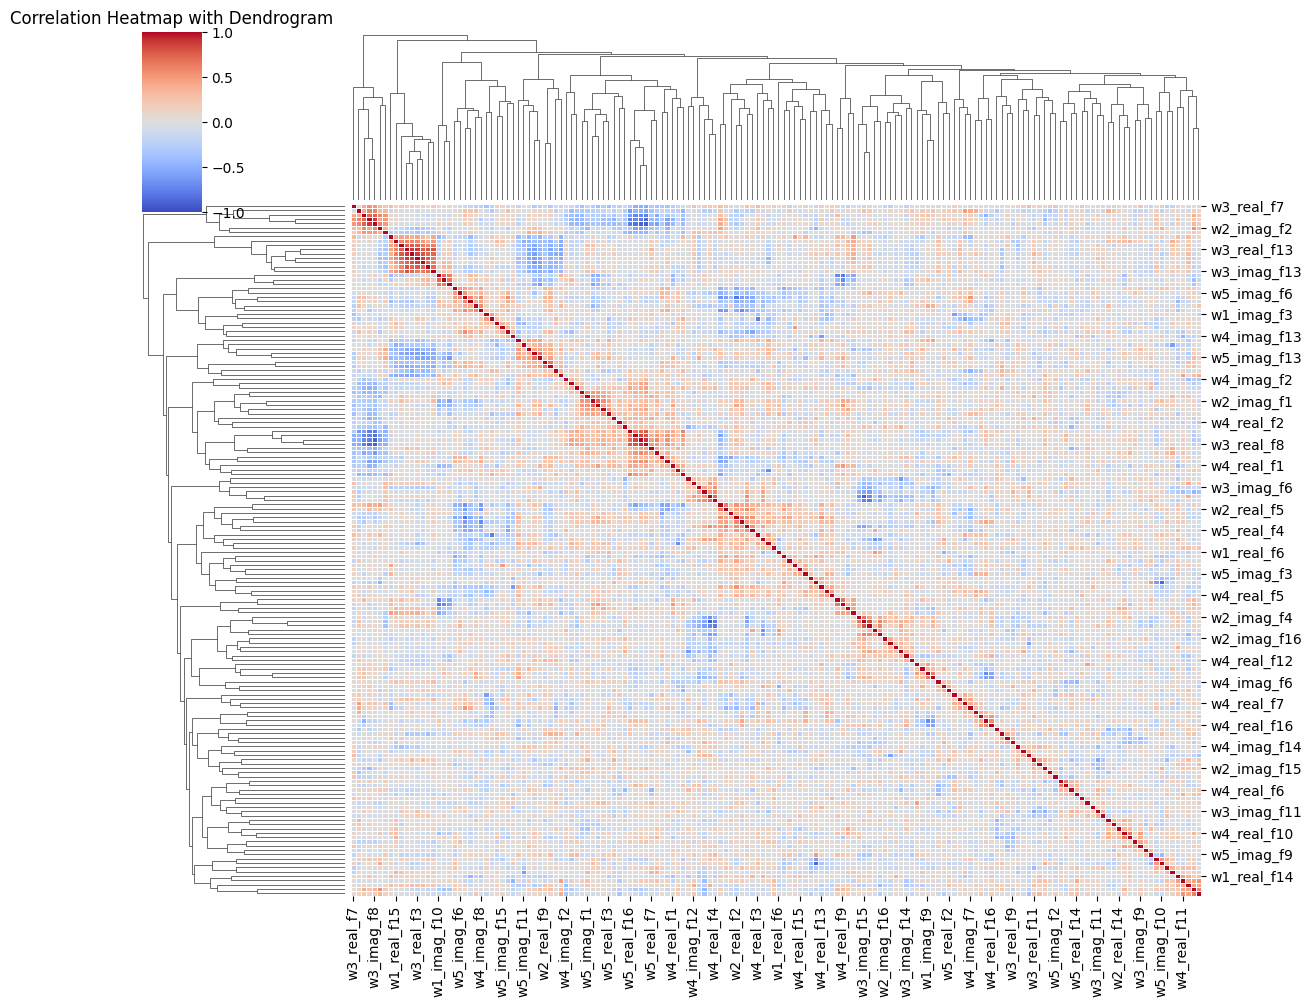

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate correlation matrix excluding "source_file" and "TW_New"
columns_to_exclude = ['source_file', 'TW_New', 'OSI_Mean']
correlation_matrix = result_df_combined.drop(columns=columns_to_exclude).corr()

# Plot heatmap with dendrogram
plt.figure(figsize=(16, 12))
sns.clustermap(correlation_matrix, cmap='coolwarm', annot=False, linewidths=0.5, figsize=(12, 10), vmin=-1, vmax=1)
plt.title('Correlation Heatmap with Dendrogram')
plt.show()


Correlation coefficients for TW_New == 1:
Correlation between w1_imag_f15 and OSI_Mean: 0.396
Correlation between w1_real_f16 and OSI_Mean: -0.378
Correlation between w1_imag_f16 and OSI_Mean: -0.303
Correlation between w1_imag_f14 and OSI_Mean: 0.264
Correlation between w1_imag_f6 and OSI_Mean: 0.257
Correlation between w1_imag_f9 and OSI_Mean: -0.186
Correlation between w1_real_f11 and OSI_Mean: -0.151
Correlation between w1_real_f12 and OSI_Mean: 0.138
Correlation between w1_imag_f2 and OSI_Mean: -0.134
Correlation between w1_imag_f7 and OSI_Mean: -0.132
Correlation between w1_imag_f8 and OSI_Mean: -0.127
Correlation between w1_imag_f11 and OSI_Mean: -0.124
Correlation between w1_imag_f12 and OSI_Mean: -0.122
Correlation between w1_real_f13 and OSI_Mean: -0.119
Correlation between w1_imag_f5 and OSI_Mean: 0.116
Correlation between w1_imag_f1 and OSI_Mean: 0.114
Correlation between w1_imag_f3 and OSI_Mean: 0.091
Correlation between w1_imag_f13 and OSI_Mean: 0.086
Correlation between 

<Figure size 1000x800 with 0 Axes>

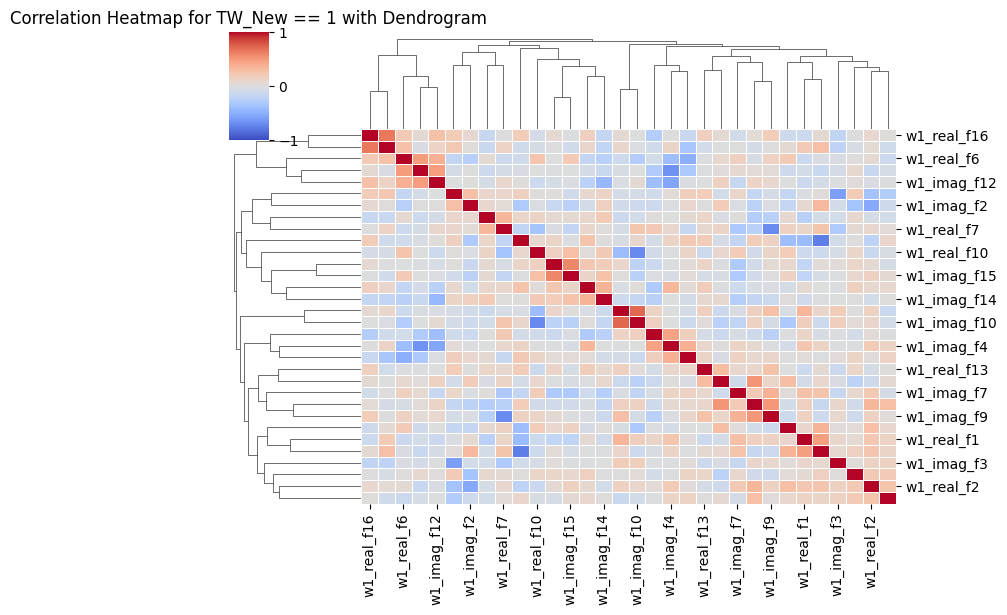

Correlation coefficients for TW_New == 2:
Correlation between w2_imag_f6 and OSI_Mean: 0.278
Correlation between w2_imag_f8 and OSI_Mean: -0.254
Correlation between w2_imag_f10 and OSI_Mean: -0.250
Correlation between w2_imag_f14 and OSI_Mean: -0.239
Correlation between w2_imag_f1 and OSI_Mean: 0.216
Correlation between w2_real_f7 and OSI_Mean: 0.204
Correlation between w2_real_f13 and OSI_Mean: -0.187
Correlation between w2_real_f6 and OSI_Mean: -0.186
Correlation between w2_real_f12 and OSI_Mean: 0.175
Correlation between w2_imag_f11 and OSI_Mean: -0.175
Correlation between w2_real_f2 and OSI_Mean: 0.157
Correlation between w2_imag_f4 and OSI_Mean: -0.137
Correlation between w2_real_f3 and OSI_Mean: 0.121
Correlation between w2_real_f5 and OSI_Mean: 0.103
Correlation between w2_imag_f3 and OSI_Mean: 0.101
Correlation between w2_imag_f13 and OSI_Mean: -0.094
Correlation between w2_imag_f2 and OSI_Mean: -0.092
Correlation between w2_real_f1 and OSI_Mean: 0.089
Correlation between w2_re

<Figure size 1000x800 with 0 Axes>

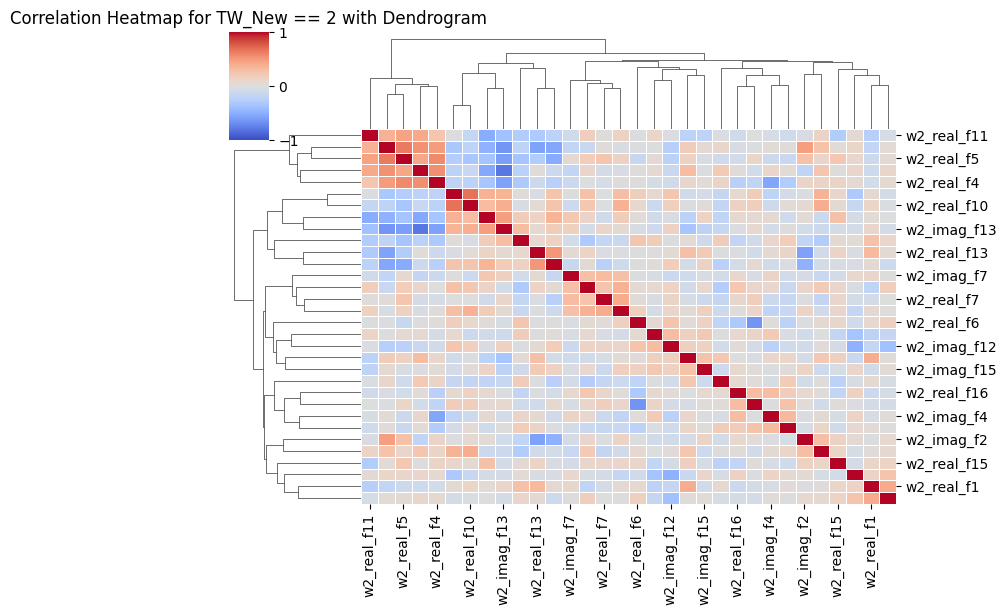

Correlation coefficients for TW_New == 3:
Correlation between w3_imag_f5 and OSI_Mean: 0.391
Correlation between w3_imag_f3 and OSI_Mean: 0.373
Correlation between w3_real_f3 and OSI_Mean: 0.332
Correlation between w3_real_f5 and OSI_Mean: 0.316
Correlation between w3_real_f13 and OSI_Mean: 0.295
Correlation between w3_imag_f13 and OSI_Mean: 0.292
Correlation between w3_imag_f6 and OSI_Mean: -0.247
Correlation between w3_real_f11 and OSI_Mean: 0.223
Correlation between w3_real_f14 and OSI_Mean: -0.205
Correlation between w3_real_f4 and OSI_Mean: 0.198
Correlation between w3_imag_f16 and OSI_Mean: -0.192
Correlation between w3_imag_f7 and OSI_Mean: -0.148
Correlation between w3_real_f10 and OSI_Mean: -0.141
Correlation between w3_imag_f9 and OSI_Mean: -0.128
Correlation between w3_real_f15 and OSI_Mean: 0.118
Correlation between w3_real_f9 and OSI_Mean: 0.116
Correlation between w3_imag_f2 and OSI_Mean: -0.106
Correlation between w3_imag_f14 and OSI_Mean: -0.098
Correlation between w3_r

<Figure size 1000x800 with 0 Axes>

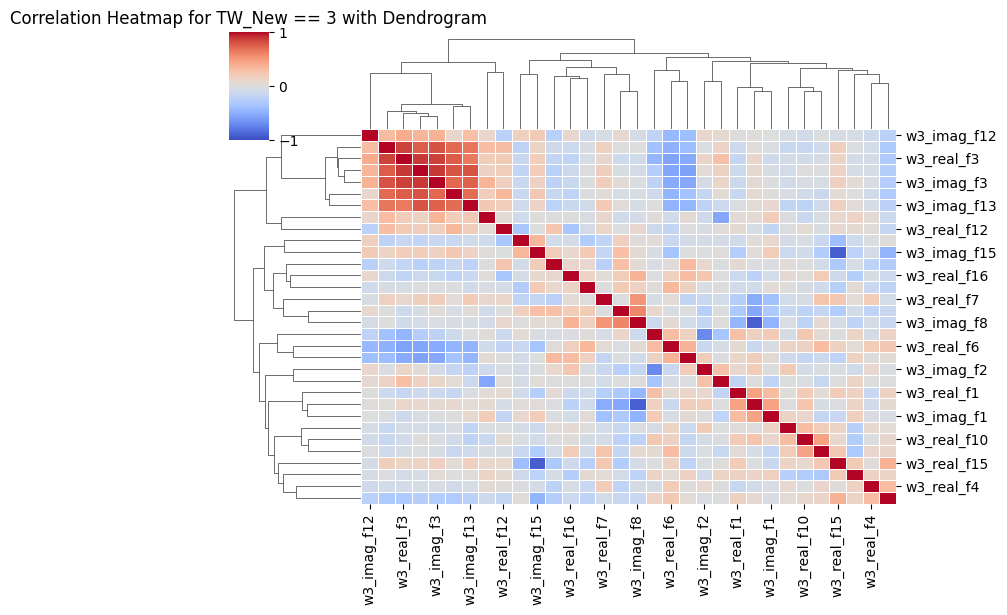

Correlation coefficients for TW_New == 4:
Correlation between w4_imag_f6 and OSI_Mean: 0.361
Correlation between w4_real_f6 and OSI_Mean: -0.314
Correlation between w4_imag_f11 and OSI_Mean: -0.229
Correlation between w4_real_f10 and OSI_Mean: -0.208
Correlation between w4_real_f5 and OSI_Mean: -0.205
Correlation between w4_real_f2 and OSI_Mean: 0.176
Correlation between w4_imag_f9 and OSI_Mean: -0.154
Correlation between w4_real_f15 and OSI_Mean: -0.146
Correlation between w4_imag_f10 and OSI_Mean: -0.125
Correlation between w4_real_f4 and OSI_Mean: -0.124
Correlation between w4_imag_f13 and OSI_Mean: -0.123
Correlation between w4_real_f3 and OSI_Mean: 0.120
Correlation between w4_real_f11 and OSI_Mean: -0.111
Correlation between w4_real_f8 and OSI_Mean: 0.111
Correlation between w4_imag_f14 and OSI_Mean: 0.105
Correlation between w4_imag_f1 and OSI_Mean: 0.102
Correlation between w4_imag_f8 and OSI_Mean: -0.102
Correlation between w4_imag_f5 and OSI_Mean: -0.102
Correlation between w

<Figure size 1000x800 with 0 Axes>

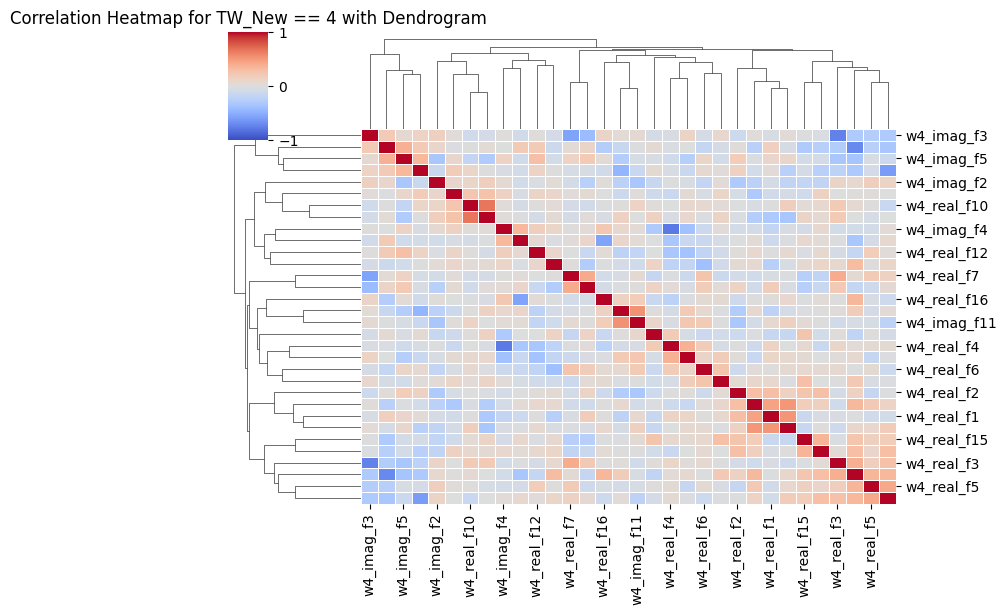

Correlation coefficients for TW_New == 5:
Correlation between w5_imag_f1 and OSI_Mean: 0.282
Correlation between w5_real_f1 and OSI_Mean: 0.279
Correlation between w5_real_f14 and OSI_Mean: -0.214
Correlation between w5_real_f2 and OSI_Mean: 0.211
Correlation between w5_imag_f4 and OSI_Mean: 0.207
Correlation between w5_imag_f13 and OSI_Mean: -0.204
Correlation between w5_real_f9 and OSI_Mean: 0.202
Correlation between w5_real_f4 and OSI_Mean: 0.186
Correlation between w5_imag_f15 and OSI_Mean: -0.184
Correlation between w5_real_f5 and OSI_Mean: -0.179
Correlation between w5_imag_f7 and OSI_Mean: -0.126
Correlation between w5_real_f12 and OSI_Mean: 0.118
Correlation between w5_real_f3 and OSI_Mean: 0.114
Correlation between w5_imag_f5 and OSI_Mean: -0.105
Correlation between w5_real_f13 and OSI_Mean: 0.101
Correlation between w5_imag_f8 and OSI_Mean: 0.095
Correlation between w5_real_f6 and OSI_Mean: -0.089
Correlation between w5_imag_f16 and OSI_Mean: -0.083
Correlation between w5_rea

<Figure size 1000x800 with 0 Axes>

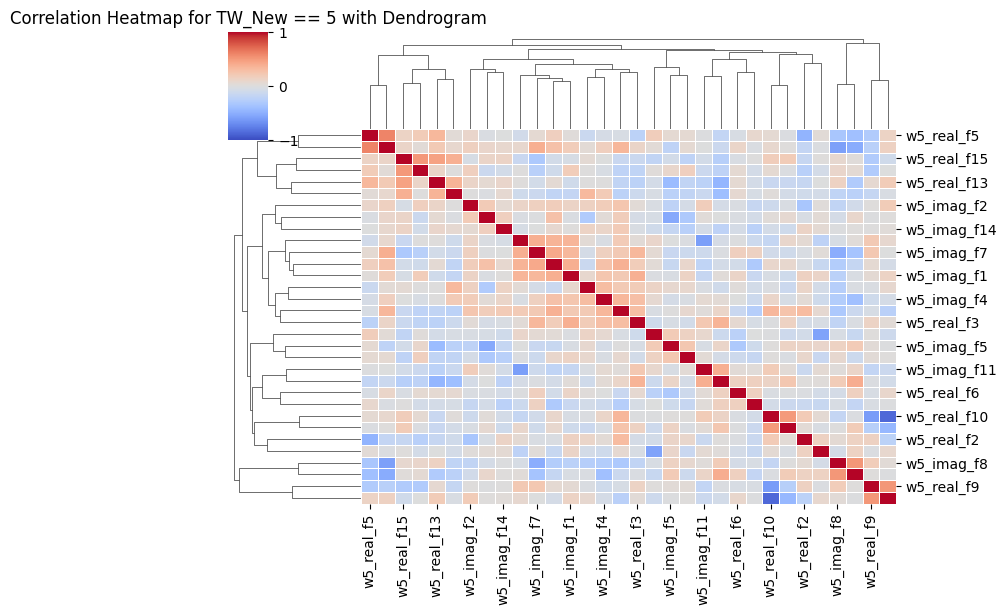

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define TW_New values
tw_values = [1, 2, 3, 4, 5]

# Loop through each TW_New value
for tw_value in tw_values:
    # Filter result_df_combined based on TW_New value
    filtered_df = result_df_combined[result_df_combined["TW_New"] == tw_value]
    
    # Subset columns containing "w1", "w2", ..., "w5" and OSI_Mean
    subset_cols = [col for col in filtered_df.columns if 'w' + str(tw_value) in col] + ['OSI_Mean']
    filtered_df_subset = filtered_df[subset_cols]
    
    # Calculate correlation matrix
    correlation_matrix = filtered_df_subset.corr()
    
    # Calculate correlation coefficients for OSI_Mean
    correlation_coefficients = {}
    for feature_name in subset_cols[:-1]:  # Exclude OSI_Mean from correlation calculation
        feature_values = filtered_df_subset[feature_name]
        correlation_coefficient = np.corrcoef(feature_values, filtered_df_subset['OSI_Mean'])[0, 1]
        correlation_coefficients[feature_name] = correlation_coefficient
    
    # Rank correlation coefficients by absolute value (from highest to lowest)
    sorted_correlations = sorted(correlation_coefficients.items(), key=lambda x: abs(x[1]), reverse=True)
    
    # Display correlation coefficients sorted by absolute value
    print(f"Correlation coefficients for TW_New == {tw_value}:")
    for feature, correlation in sorted_correlations:
        print(f"Correlation between {feature} and OSI_Mean: {correlation:.3f}")
    
    # Calculate correlation matrix excluding "OSI_Mean"
    correlation_matrix = filtered_df_subset.drop(columns=['OSI_Mean']).corr()
    
    # Plot heatmap with dendrogram
    plt.figure(figsize=(10, 8))
    sns.clustermap(correlation_matrix, cmap='coolwarm', annot=False, linewidths=0.5, figsize=(8, 6), vmin=-1, vmax=1)
    plt.title(f'Correlation Heatmap for TW_New == {tw_value} with Dendrogram')
    plt.show()


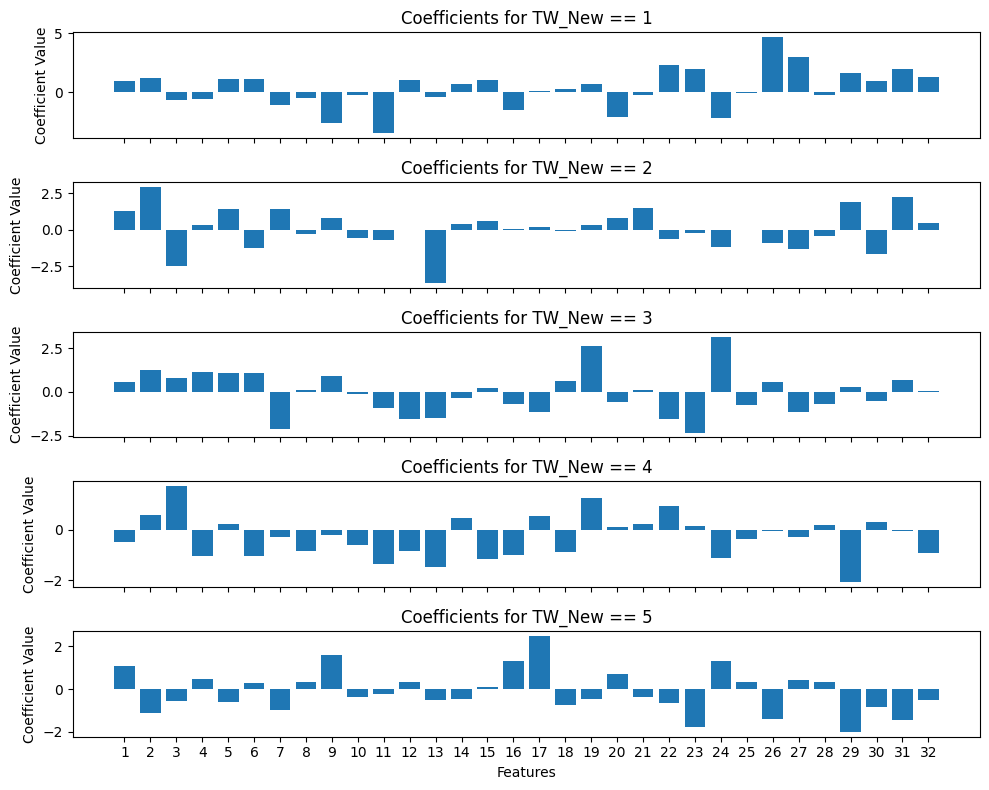

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

# Define TW_New values
tw_values = [1, 2, 3, 4, 5]

# Initialize a figure and axis
fig, axs = plt.subplots(len(tw_values), 1, figsize=(10, 8), sharex=True)

# Loop through each TW_New value
for i, tw_value in enumerate(tw_values):
    # Filter result_df based on TW_New value
    filtered_df = result_df_combined[result_df_combined["TW_New"] == tw_value]
    
    # Subset columns containing "w1", "w2", ..., "w5"
    subset_cols = [col for col in filtered_df.columns if 'w' + str(tw_value) in col]
    filtered_df_subset = filtered_df[subset_cols + ['OSI_Mean']]
    
    # Separate features and target
    X = filtered_df_subset.drop(columns=['OSI_Mean'])
    y = filtered_df_subset['OSI_Mean']
    
    # Add constant to X for statsmodels
    X = sm.add_constant(X)
    
    # Fit OLS (Ordinary Least Squares) model
    model = sm.OLS(y, X)
    results = model.fit()
    
    # Extract coefficients (excluding constant term)
    coefficients = results.params.drop('const')
    
    # Plot bar plot of coefficients
    x_values = np.arange(len(subset_cols)) + 1  # Generate x values from 1 to length of subset_cols
    axs[i].bar(x_values, coefficients.values)  # Plot coefficients with adjusted x values
    axs[i].set_title(f'Coefficients for TW_New == {tw_value}')
    axs[i].set_ylabel('Coefficient Value')
    
    # Set x-axis ticks and labels for all 160 features
    axs[i].set_xticks(x_values)
    axs[i].set_xticklabels(x_values)  # Set labels to match the x values
    
# Set common x-axis label
plt.xlabel('Features')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


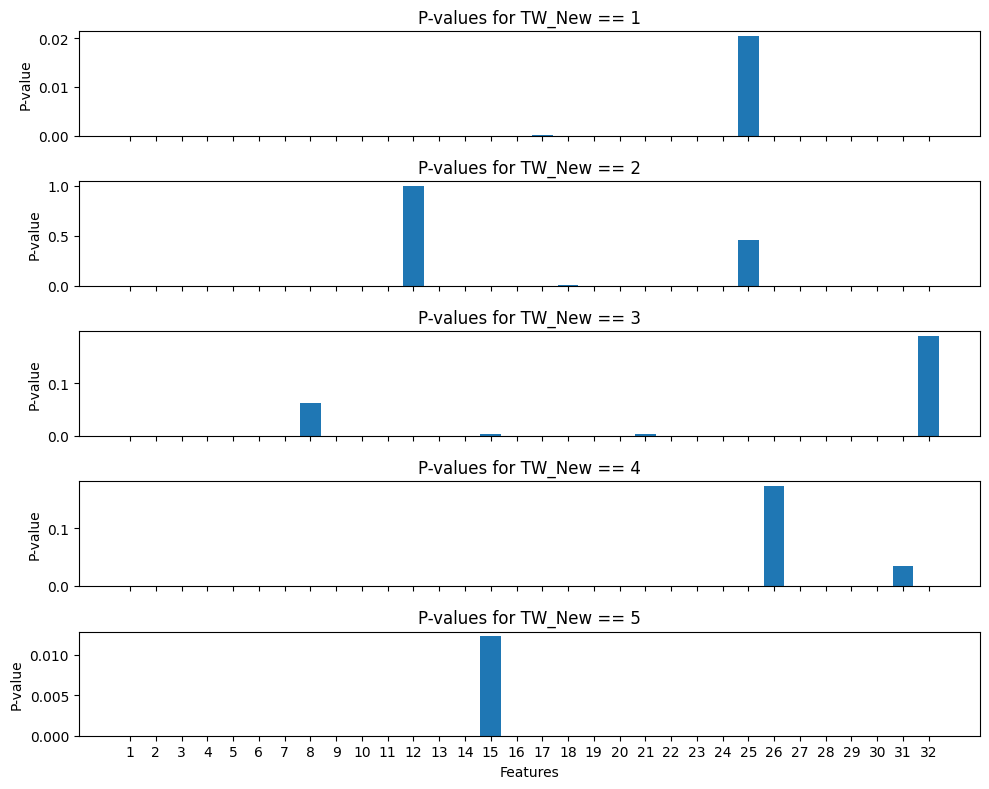

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

# Define TW_New values
tw_values = [1, 2, 3, 4, 5]

# Initialize a figure and axis
fig, axs = plt.subplots(len(tw_values), 1, figsize=(10, 8), sharex=True)

# Loop through each TW_New value
for i, tw_value in enumerate(tw_values):
    # Filter result_df based on TW_New value
    filtered_df = result_df_combined[result_df_combined["TW_New"] == tw_value]
    
    # Subset columns containing "w1", "w2", ..., "w5"
    subset_cols = [col for col in filtered_df.columns if 'w' + str(tw_value) in col]
    filtered_df_subset = filtered_df[subset_cols + ['OSI_Mean']]
    
    # Separate features and target
    X = filtered_df_subset.drop(columns=['OSI_Mean'])
    y = filtered_df_subset['OSI_Mean']
    
    # Add constant to X for statsmodels
    X = sm.add_constant(X)
    
    # Fit OLS (Ordinary Least Squares) model
    model = sm.OLS(y, X)
    results = model.fit()
    
    # Extract p-values
    p_values = results.pvalues.drop('const')  # Drop constant term p-value
    
    # Plot bar plot of coefficients
    x_values = np.arange(len(subset_cols)) + 1  # Generate x values from 1 to length of subset_cols
    axs[i].bar(x_values, p_values.values)  # Plot coefficients with adjusted x values
    axs[i].set_title(f'P-values for TW_New == {tw_value}')
    axs[i].set_ylabel('P-value')
    
    # Set x-axis ticks and labels for all 160 features
    axs[i].set_xticks(x_values)
    axs[i].set_xticklabels(x_values)  # Set labels to match the x values
    
# Set common x-axis label
plt.xlabel('Features')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


In [36]:
# Run regression model on the 160 features
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')


Mean Squared Error: 2.245269708968232
